In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Thu Jul  6 18:40:29 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100-SXM...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   32C    P0    44W / 400W |      0MiB / 40960MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 89.6 gigabytes of available RAM

You are using a high-RAM runtime!


In [2]:
import glob
from skimage.io import imread
import numpy as np
import albumentations as A
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, Activation, MaxPool2D, Dropout, BatchNormalization, Dense, Flatten, LayerNormalization
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import LearningRateScheduler
from sklearn.metrics import classification_report, f1_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import pickle


In [ ]:
def norm_bands(tif):
    return (tif - tif.min())/(tif.max() - tif.min())

## Mount Gdrive

In [3]:
from google.colab import drive
drive.mount("/content/drive")


Mounted at /content/drive


## Load X and Y sets

In [4]:
# Read from google drive
X = np.load("/content/drive/MyDrive/training/X_full.npy")
Y = np.load("/content/drive/MyDrive/training/Y_full.npy")

In [ ]:
# Run if shuffled datasets are wanted
shuffler = np.random.permutation(len(X))
X = X[shuffler]
Y = Y[shuffler]

In [ ]:
# Run if you want to get get only S2 bands
X = X[:, :, :, :13]
#X = np.expand_dims(X, axis = -1)
X.shape

(3910, 20, 20, 13)

In [5]:
print("X shape:", X.shape)
print("Y shape:", Y.shape)

X shape: (3909, 20, 20, 14)
Y shape: (3909, 1)


## Define training, validation and test sets

In [6]:
X_train, X_val, y_train, y_val = train_test_split(X, Y, test_size = 0.2, random_state = 13)
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size = 0.2, random_state = 13)

In [7]:
# Shapes of sets
print("X_train: ", X_train.shape)
print("X_val: ", X_val.shape)
print("X_test: ", X_test.shape)
print("y_train: ", y_train.shape)
print("y_val: ", y_val.shape)
print("y_test: ", y_test.shape)

X_train:  (2501, 20, 20, 14)
X_val:  (782, 20, 20, 14)
X_test:  (626, 20, 20, 14)
y_train:  (2501, 1)
y_val:  (782, 1)
y_test:  (626, 1)


In [8]:
def see_balance_in_set(set):
    print(np.unique(set.ravel(), return_counts = True))

In [9]:
# Check if classes are balanced
see_balance_in_set(y_train)
see_balance_in_set(y_val)
see_balance_in_set(y_test)

(array([0, 1], dtype=int32), array([1266, 1235]))
(array([0, 1], dtype=int32), array([366, 416]))
(array([0, 1], dtype=int32), array([323, 303]))


## Own architecture

In [ ]:
model = Sequential()

# 1st Conv layer
model.add(Conv2D(32, (3, 3), padding = "same", input_shape = (20, 20, 14)))
model.add(BatchNormalization())
model.add(Activation("relu"))

# 2nd Conv layer
model.add(Conv2D(32, (3, 3), padding = "valid"))
model.add(Activation("relu"))
model.add(Dropout(0.5))

# 3rd conv layer
model.add(Conv2D(64, (3, 3), padding = "same"))
model.add(Activation("relu"))
model.add(Dropout(0.5))

# 4th conv layer
model.add(Conv2D(64, (2, 2), padding = "valid"))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(MaxPool2D(2, 2))
model.add(Dropout(0.5))

# Dense layer
model.add(Flatten())
model.add(Dense(512, activation = "relu"))
model.add(Dropout(0.4))
model.add(Dense(1, activation = "sigmoid"))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 20, 20, 32)        4064      
                                                                 
 batch_normalization (BatchN  (None, 20, 20, 32)       128       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 20, 20, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 18, 18, 32)        9248      
                                                                 
 activation_1 (Activation)   (None, 18, 18, 32)        0         
                                                                 
 dropout (Dropout)           (None, 18, 18, 32)        0         
                                                        

In [ ]:
# scheduler that got 77% acc
def scheduler(epoch, lr):
   l = 0.0001
   if epoch > 150:
       l = 0.00001

   return l

In [ ]:
callback = LearningRateScheduler(scheduler, verbose = 1)

In [ ]:
optim = optimizers.Adam()

In [ ]:
model.compile(loss = "binary_crossentropy",
              optimizer = optim,
              metrics = ["acc"])

In [ ]:
history = model.fit(X_train,
                    y_train,
                    validation_data = (X_val, y_val),
                    epochs = 1000,
                    callbacks = [callback],
                    batch_size = 128,
                    shuffle = True)


Epoch 1: LearningRateScheduler setting learning rate to 0.0001.
Epoch 1/1000
20/20 [==============================] - 14s 40ms/step - loss: 1.1998 - acc: 0.4942 - val_loss: 0.7382 - val_acc: 0.5128 - lr: 1.0000e-04

Epoch 2: LearningRateScheduler setting learning rate to 0.0001.
Epoch 2/1000
20/20 [==============================] - 0s 9ms/step - loss: 0.9738 - acc: 0.5166 - val_loss: 0.7012 - val_acc: 0.5080 - lr: 1.0000e-04

Epoch 3: LearningRateScheduler setting learning rate to 0.0001.
Epoch 3/1000
20/20 [==============================] - 0s 9ms/step - loss: 0.8923 - acc: 0.4934 - val_loss: 0.7326 - val_acc: 0.5128 - lr: 1.0000e-04

Epoch 4: LearningRateScheduler setting learning rate to 0.0001.
Epoch 4/1000
20/20 [==============================] - 0s 9ms/step - loss: 0.7984 - acc: 0.5202 - val_loss: 0.7049 - val_acc: 0.5128 - lr: 1.0000e-04

Epoch 5: LearningRateScheduler setting learning rate to 0.0001.
Epoch 5/1000
20/20 [==============================] - 0s 9ms/step - loss: 0.7

dict_keys(['loss', 'acc', 'val_loss', 'val_acc', 'lr'])


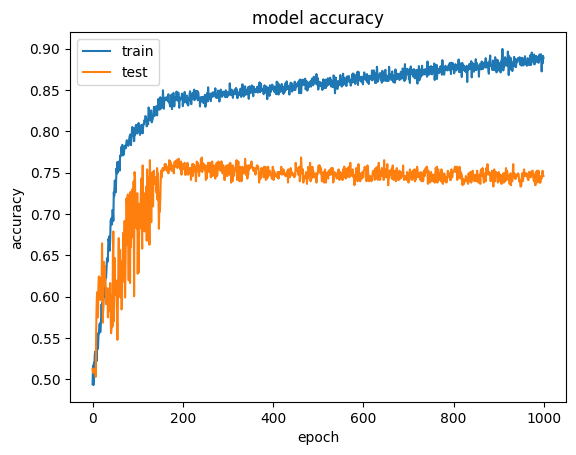

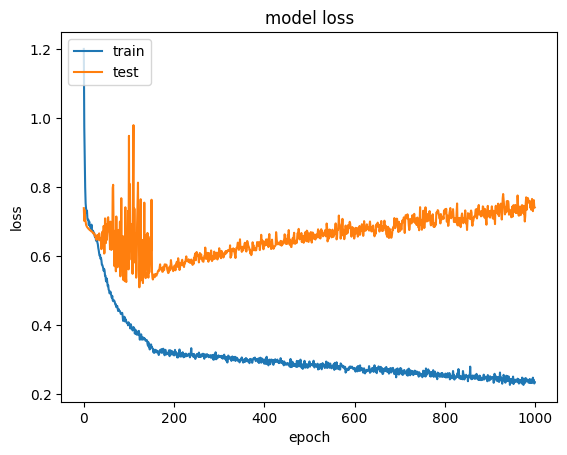

In [ ]:
# list all data in history
print(history.history.keys())

# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
results = model.evaluate(X_test, y_test)
print("test_loss, test_acc:", results)

25/25 [==============================] - 0s 6ms/step - loss: 0.7405 - acc: 0.7826
test_loss, test_acc: [0.740469753742218, 0.782608687877655]


In [ ]:
# See predictions by class
model_pred = model.predict(X_test, batch_size = 64)

print(classification_report(y_test, np.where(model_pred > 0.5, 1, 0)))

13/13 [==============================] - 0s 2ms/step
              precision    recall  f1-score   support

           0       0.76      0.84      0.80       399
           1       0.81      0.73      0.77       383

    accuracy                           0.78       782
   macro avg       0.79      0.78      0.78       782
weighted avg       0.79      0.78      0.78       782



In [ ]:
# Save 78% acc model
model.save("/content/drive/MyDrive/models/model_78acc.keras")

## Model Chen

Based on the paper Chen et al. (2020). Augmenting a deep-learning algorithm with canal inspection knowledge for reliable water leak detection from multispectral satellite images. https://doi.org/10.1016/j.aei.2020.101161

In [ ]:
model_chen = Sequential()

# 1st Conv layer
model_chen.add(Conv2D(32, kernel_size = (3, 3), input_shape = (20, 20, 14), padding = "same"))
model_chen.add(BatchNormalization())
model_chen.add(Activation("relu"))
model_chen.add(MaxPool2D(2, 2))

# 2nd Conv layer
model_chen.add(Conv2D(32, kernel_size = (3, 3), padding = "same"))
model_chen.add(Activation("relu"))
model_chen.add(MaxPool2D(2, 2))
model_chen.add(Dropout(0.5))


# 3rd Conv layer
model_chen.add(Conv2D(64, kernel_size = (3, 3), padding = "same"))
model_chen.add(BatchNormalization())
model_chen.add(Activation("relu"))
model_chen.add(Dropout(0.3))
model_chen.add(MaxPool2D(2, 2))

# Dense layer
model_chen.add(Flatten())
model_chen.add(Dense(128, activation = "relu"))
model_chen.add(Dropout(0.5))
model_chen.add(Dense(1, activation = "sigmoid"))

model_chen.summary()


Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_49 (Conv2D)          (None, 20, 20, 32)        4064      
                                                                 
 batch_normalization_21 (Bat  (None, 20, 20, 32)       128       
 chNormalization)                                                
                                                                 
 activation_63 (Activation)  (None, 20, 20, 32)        0         
                                                                 
 max_pooling2d_29 (MaxPoolin  (None, 10, 10, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_50 (Conv2D)          (None, 10, 10, 32)        9248      
                                                                 
 activation_64 (Activation)  (None, 10, 10, 32)      

In [ ]:
optim = optimizers.Adam(learning_rate = 0.001)

In [ ]:
model_chen.compile(loss = "binary_crossentropy",
                   optimizer = optim,
                   metrics = ["acc"])


In [ ]:
history_chen = model_chen.fit(X_train,
                         y_train,
                         validation_data = (X_val, y_val),
                         epochs = 200,
                         batch_size = 512)

Epoch 1/200
5/5 [==============================] - 3s 66ms/step - loss: 1.0164 - acc: 0.4858 - val_loss: 0.8599 - val_acc: 0.4629
Epoch 2/200
5/5 [==============================] - 0s 17ms/step - loss: 0.7797 - acc: 0.5138 - val_loss: 0.9208 - val_acc: 0.4680
Epoch 3/200
5/5 [==============================] - 0s 17ms/step - loss: 0.7113 - acc: 0.5346 - val_loss: 1.2294 - val_acc: 0.4680
Epoch 4/200
5/5 [==============================] - 0s 17ms/step - loss: 0.6983 - acc: 0.5394 - val_loss: 1.5211 - val_acc: 0.4680
Epoch 5/200
5/5 [==============================] - 0s 18ms/step - loss: 0.6860 - acc: 0.5338 - val_loss: 1.5421 - val_acc: 0.4680
Epoch 6/200
5/5 [==============================] - 0s 18ms/step - loss: 0.6807 - acc: 0.5314 - val_loss: 1.5911 - val_acc: 0.4680
Epoch 7/200
5/5 [==============================] - 0s 18ms/step - loss: 0.6816 - acc: 0.5534 - val_loss: 1.5801 - val_acc: 0.4680
Epoch 8/200
5/5 [==============================] - 0s 18ms/step - loss: 0.6784 - acc: 0.56

dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])


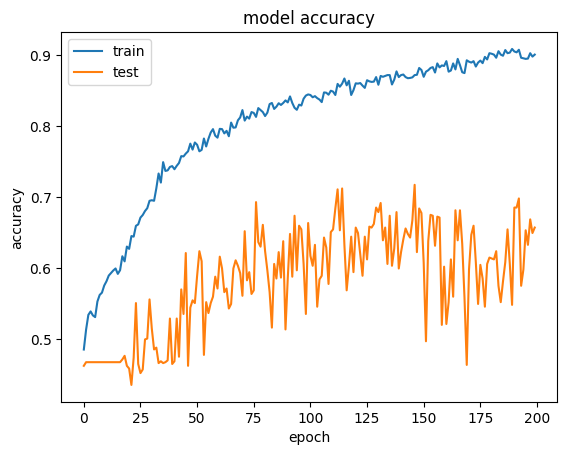

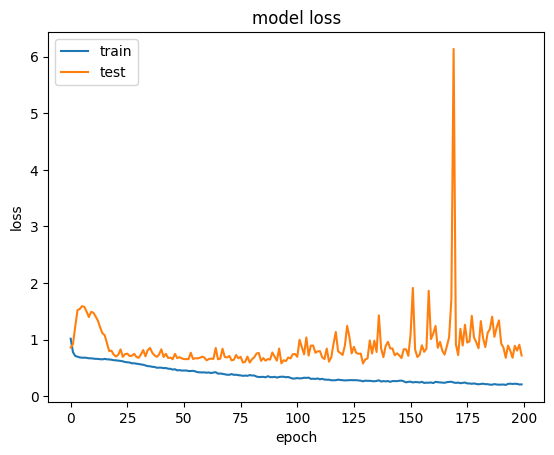

In [ ]:
# list all data in history_chen
print(history_chen.history.keys())
# summarize history_chen for accuracy
plt.plot(history_chen.history['acc'])
plt.plot(history_chen.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history_chen for loss
plt.plot(history_chen.history['loss'])
plt.plot(history_chen.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
results_chen = model_chen.evaluate(X_test, y_test, batch_size = 64)
print("test_loss, test_acc:", results_chen)

10/10 [==============================] - 0s 10ms/step - loss: 1.4270 - acc: 0.6422
test_loss, test_acc: [1.426953911781311, 0.6421725153923035]


In [ ]:
# See predictions by class
model_chen_pred = model_chen.predict(X_test, batch_size = 64)

print(classification_report(y_test, np.where(model_chen_pred > 0.5, 1, 0)))

10/10 [==============================] - 0s 3ms/step
              precision    recall  f1-score   support

           0       0.69      0.77      0.73       323
           1       0.72      0.63      0.67       303

    accuracy                           0.70       626
   macro avg       0.70      0.70      0.70       626
weighted avg       0.70      0.70      0.70       626



In [ ]:
# Save 79% acc model
model_chen.save("/content/drive/MyDrive/models/model_79acc.keras")

## Simple architecture

In [ ]:
model_simple = Sequential()

# 1st Conv Layer
model_simple.add(Conv2D(32, (2, 2), padding = "same", strides = (1, 1), input_shape = (20, 20, 14)))
model_simple.add(BatchNormalization())
model_simple.add(Activation("relu"))
model_simple.add(Dropout(0.2))

# 2nd Conv layer
model_simple.add(Conv2D(64, (4, 4), padding = "same", strides = (1, 1)))
model_simple.add(BatchNormalization())
model_simple.add(Activation("relu"))
model_simple.add(Dropout(0.5))

# 3rd Conv layer
model_simple.add(Conv2D(128, (2, 2), padding = "same", strides = (2, 2)))
model_simple.add(BatchNormalization())
model_simple.add(Activation("relu"))
model_simple.add(Dropout(0.5))
model_simple.add(MaxPool2D(2, 2))

# Dense layer
model_simple.add(Flatten())
model_simple.add(Dense(256))
model_simple.add(Activation("relu"))
model_simple.add(Dropout(0.6))
model_simple.add(Dense(512))
model_simple.add(Activation("relu"))
model_simple.add(Dropout(0.3))
model_simple.add(Dense(1))
model_simple.add(Activation("sigmoid"))

model_simple.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 20, 20, 32)        1824      
                                                                 
 batch_normalization (BatchN  (None, 20, 20, 32)       128       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 20, 20, 32)        0         
                                                                 
 dropout (Dropout)           (None, 20, 20, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 20, 20, 64)        32832     
                                                                 
 batch_normalization_1 (Batc  (None, 20, 20, 64)       256       
 hNormalization)                                        

In [ ]:
def scheduler(epoch, lr):
    l = 0.0001
    if epoch > 200:
        l = 0.00001
    if epoch > 400:
        l = 0.000015
    if epoch > 600:
        l = 0.000001
    if epoch > 700:
        l = 0.000025
    if epoch > 850:
        l = 0.00004

    return l

In [ ]:
callback = LearningRateScheduler(scheduler, verbose = 1)

In [ ]:
optim_simple = optimizers.Adam()

In [ ]:
model_simple.compile(optimizer = optim_simple,
                     loss = "binary_crossentropy",
                     metrics = ["acc"])

In [ ]:
history_simple = model_simple.fit(X_train,
                                  y_train,
                                  validation_data = (X_val, y_val),
                                  callbacks = [callback],
                                  epochs = 1000,
                                  batch_size = 512)


Epoch 1: LearningRateScheduler setting learning rate to 0.0001.
Epoch 1/1000
5/5 [==============================] - 15s 213ms/step - loss: 1.0125 - acc: 0.5090 - val_loss: 1.1180 - val_acc: 0.5102 - lr: 1.0000e-04

Epoch 2: LearningRateScheduler setting learning rate to 0.0001.
Epoch 2/1000
5/5 [==============================] - 0s 24ms/step - loss: 0.9358 - acc: 0.5018 - val_loss: 1.1179 - val_acc: 0.5102 - lr: 1.0000e-04

Epoch 3: LearningRateScheduler setting learning rate to 0.0001.
Epoch 3/1000
5/5 [==============================] - 0s 22ms/step - loss: 0.8631 - acc: 0.4942 - val_loss: 1.2627 - val_acc: 0.5102 - lr: 1.0000e-04

Epoch 4: LearningRateScheduler setting learning rate to 0.0001.
Epoch 4/1000
5/5 [==============================] - 0s 23ms/step - loss: 0.7859 - acc: 0.5154 - val_loss: 1.0370 - val_acc: 0.5102 - lr: 1.0000e-04

Epoch 5: LearningRateScheduler setting learning rate to 0.0001.
Epoch 5/1000
5/5 [==============================] - 0s 22ms/step - loss: 0.7681 -

dict_keys(['loss', 'acc', 'val_loss', 'val_acc', 'lr'])


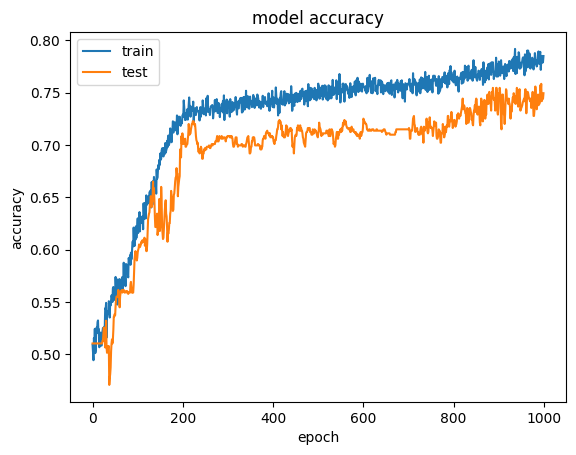

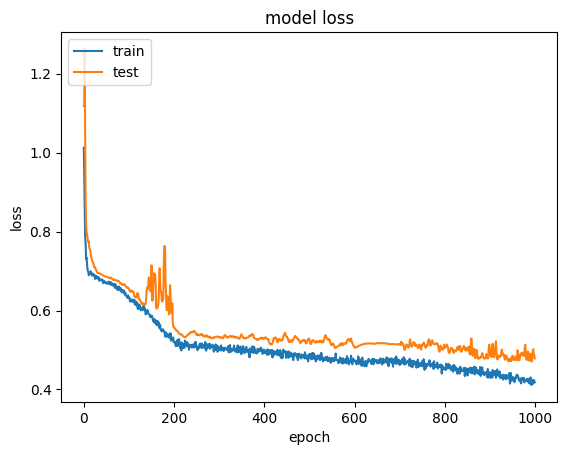

In [ ]:
# list all data in history_simple
print(history_simple.history.keys())
# summarize history_simple for accuracy
plt.plot(history_simple.history['acc'])
plt.plot(history_simple.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history_simple for loss
plt.plot(history_simple.history['loss'])
plt.plot(history_simple.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
# Save model because it has a balanced performance
model_simple.save("/content/drive/MyDrive/models/base_model.keras")

# Save history of base model
with open('/content/drive/MyDrive/models/base_model_history', 'wb') as file_pi:
    pickle.dump(history_simple.history, file_pi)

Next I'll continue the training of the simple model but with different learning schedules.

In [15]:
model_simple_c = Sequential()

# 1st Conv Layer
model_simple_c.add(Conv2D(32, (2, 2), padding = "same", strides = (1, 1), input_shape = (20, 20, 14)))
model_simple_c.add(BatchNormalization())
model_simple_c.add(Activation("relu"))
model_simple_c.add(Dropout(0.2))

# 2nd Conv layer
model_simple_c.add(Conv2D(64, (4, 4), padding = "same", strides = (1, 1)))
model_simple_c.add(BatchNormalization())
model_simple_c.add(Activation("relu"))
model_simple_c.add(Dropout(0.5))

# 3rd Conv layer
model_simple_c.add(Conv2D(128, (2, 2), padding = "same", strides = (2, 2)))
model_simple_c.add(BatchNormalization())
model_simple_c.add(Activation("relu"))
model_simple_c.add(Dropout(0.5))
model_simple_c.add(MaxPool2D(2, 2))

# Dense layer
model_simple_c.add(Flatten())
model_simple_c.add(Dense(256))
model_simple_c.add(Activation("relu"))
model_simple_c.add(Dropout(0.6))
model_simple_c.add(Dense(512))
model_simple_c.add(Activation("relu"))
model_simple_c.add(Dropout(0.3))
model_simple_c.add(Dense(1))
model_simple_c.add(Activation("sigmoid"))

model_simple_c.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 20, 20, 32)        1824      
                                                                 
 batch_normalization (BatchN  (None, 20, 20, 32)       128       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 20, 20, 32)        0         
                                                                 
 dropout (Dropout)           (None, 20, 20, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 20, 20, 64)        32832     
                                                                 
 batch_normalization_1 (Batc  (None, 20, 20, 64)       256       
 hNormalization)                                        

In [16]:
# Load base model
base_model = load_model("/content/drive/MyDrive/models/base_model.keras")

# Set weights from base model
model_simple_c.set_weights(base_model.get_weights())

In [17]:
def scheduler(epoch, lr):
    l = 0.000001
    if epoch > 200:
        l = 0.00005
    if epoch > 400:
        l = 0.000015
    if epoch > 600:
        l = 0.000001
    if epoch > 700:
        l = 0.000025
    if epoch > 850:
        l = 0.00004

    return l

In [18]:
callback = LearningRateScheduler(scheduler, verbose = 1)

In [19]:
optim_simple_c = optimizers.Adam()

In [20]:
model_simple_c.compile(optimizer = optim_simple_c,
                     loss = "binary_crossentropy",
                     metrics = ["acc"])

In [21]:
history_simple_c = model_simple_c.fit(X_train,
                                  y_train,
                                  validation_data = (X_val, y_val),
                                  callbacks = [callback],
                                  epochs = 300,
                                  batch_size = 256)


Epoch 1: LearningRateScheduler setting learning rate to 1e-06.
Epoch 1/300
10/10 [==============================] - 14s 74ms/step - loss: 0.4771 - acc: 0.7689 - val_loss: 0.4405 - val_acc: 0.7801 - lr: 1.0000e-06

Epoch 2: LearningRateScheduler setting learning rate to 1e-06.
Epoch 2/300
10/10 [==============================] - 0s 12ms/step - loss: 0.4720 - acc: 0.7597 - val_loss: 0.4418 - val_acc: 0.7801 - lr: 1.0000e-06

Epoch 3: LearningRateScheduler setting learning rate to 1e-06.
Epoch 3/300
10/10 [==============================] - 0s 12ms/step - loss: 0.4719 - acc: 0.7609 - val_loss: 0.4435 - val_acc: 0.7788 - lr: 1.0000e-06

Epoch 4: LearningRateScheduler setting learning rate to 1e-06.
Epoch 4/300
10/10 [==============================] - 0s 12ms/step - loss: 0.4712 - acc: 0.7665 - val_loss: 0.4450 - val_acc: 0.7749 - lr: 1.0000e-06

Epoch 5: LearningRateScheduler setting learning rate to 1e-06.
Epoch 5/300
10/10 [==============================] - 0s 12ms/step - loss: 0.4563 - 

The red line in the following plots represents the performance of the model after implementing the new learning schedule.

dict_keys(['loss', 'acc', 'val_loss', 'val_acc', 'lr'])


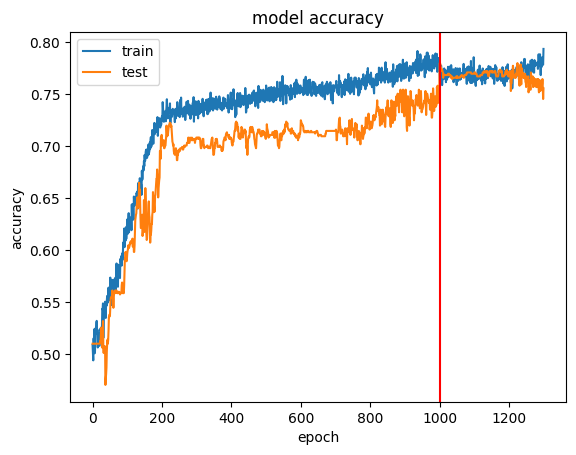

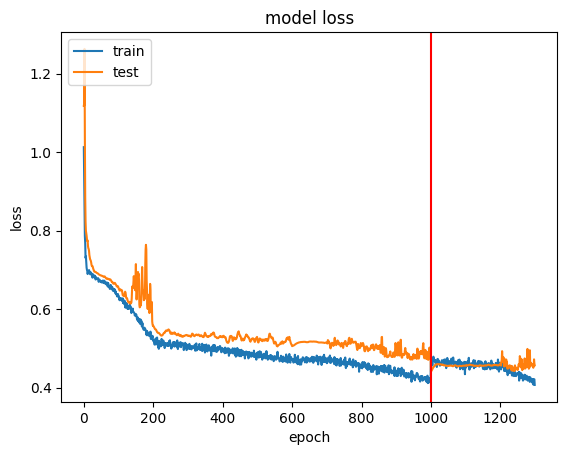

In [22]:
# Load history from base model
with open("/content/drive/MyDrive/models/base_model_history", "rb") as file_pi:
    base_model_history = pickle.load(file_pi)

# Append data from fine tuning history
for key in base_model_history.keys():
    for i in range(0, len(history_simple_c.history[key])):
        value = history_simple_c.history[key][i]
        base_model_history[key].append(value)

# list all data in_simple_c
print(base_model_history.keys())
# summarize base_model for accuracy
plt.plot(base_model_history['acc'])
plt.plot(base_model_history['val_acc'])
plt.axvline(x = 1000, color = "r")
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize base_model for loss
plt.plot(base_model_history['loss'])
plt.plot(base_model_history['val_loss'])
plt.axvline(x = 1000, color = "r")
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [23]:
model_simple_c.evaluate(X_test, y_test)

20/20 [==============================] - 0s 6ms/step - loss: 0.4032 - acc: 0.8051


[0.4032142758369446, 0.805111825466156]

In [24]:
# See predictions by class
model_simple_c_pred = model_simple_c.predict(X_test, batch_size = 64)

print(classification_report(y_test, np.where(model_simple_c_pred > 0.5, 1, 0)))

10/10 [==============================] - 0s 8ms/step
              precision    recall  f1-score   support

           0       0.88      0.72      0.79       323
           1       0.75      0.89      0.82       303

    accuracy                           0.81       626
   macro avg       0.81      0.81      0.80       626
weighted avg       0.82      0.81      0.80       626



In [27]:
# Save model with 81% accuracy
model_simple_c.save("/content/drive/MyDrive/models/model_81acc.keras")

# Save history of model with 81% accuracy
with open('/content/drive/MyDrive/models/model_81acc_history', 'wb') as file_pi:
    pickle.dump(base_model_history, file_pi)